# Education as a Happiness predictor

## 1.Data preparation and cleaning

### 1.1 Import Utilities Library

##### Click "Run long executions" for dataset file prepararion and model training
##### Click "Don't show plots" for disabling graphics

In [1]:
%matplotlib inline
from utilities import *

### 1.2 Obtaining the Dataset file

In [2]:
if not button_exec.value:
    DataPreparation.obtainDataFromLocalDBs()

### 1.3 Loading the Dataset file

In [3]:
overall_data = pd.read_csv(DataPreparation.retriveMergedFilePath(),\
                           header=0, index_col=0, skiprows=0, encoding='iso-8859-1')
overall_data.head(5)

,country,year,"Adjusted net enrolment rate, lower secondary, both sexes (%)","Adjusted net enrolment rate, lower secondary, female (%)","Adjusted net enrolment rate, lower secondary, gender parity index (GPI)","Adjusted net enrolment rate, lower secondary, male (%)","Adjusted net enrolment rate, primary, both sexes (%)","Adjusted net enrolment rate, primary, female (%)","Adjusted net enrolment rate, primary, gender parity index (GPI)","Adjusted net enrolment rate, primary, male (%)",...,Wittgenstein Projection: Population in thousands by highest level of educational attainment. Upper Secondary. Total,"Youth illiterate population, 15-24 years, % female","Youth illiterate population, 15-24 years, both sexes (number)","Youth illiterate population, 15-24 years, female (number)","Youth illiterate population, 15-24 years, male (number)","Youth literacy rate, population 15-24 years, both sexes (%)","Youth literacy rate, population 15-24 years, female (%)","Youth literacy rate, population 15-24 years, gender parity index (GPI)","Youth literacy rate, population 15-24 years, male (%)",Happy Planet Index
0,Afghanistan,2012.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.8
1,Afghanistan,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.2
2,Albania,2006.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.1
3,Albania,2009.0,NaN,NaN,NaN,NaN,89.393333,88.698219,0.98508,90.041763,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.9
4,Albania,2012.0,NaN,NaN,NaN,NaN,96.137093,95.353287,0.98445,96.859650,...,NaN,58.875946,4302.0,2533.0,1769.0,99.2314,99.020187,0.99642,99.375977,54.1


### 1.4 Drop columns and rows with %(nulls)>80%

In [4]:
THRESH = 0.2
overall_data = overall_data.dropna(1, thresh=(overall_data.shape[0] * (1 - THRESH)))
overall_data = overall_data.dropna(0, thresh=(overall_data.shape[1] * (1 - THRESH)))
overall_data.head(5)

,country,year,"Enrolment in primary education, both sexes (number)","Enrolment in primary education, female (number)",GDP at market prices (constant 2005 US$),GDP at market prices (current US$),GDP per capita (constant 2005 US$),GDP per capita (current US$),GNI (current US$),"GNI per capita, Atlas method (current US$)",...,"Population, male (% of total)","Population, total","School life expectancy, primary, both sexes (years)","School life expectancy, primary, female (years)","School life expectancy, primary, gender parity index (GPI)","School life expectancy, primary, male (years)",Theoretical duration of pre-primary education (years),Theoretical duration of primary education (years),Theoretical duration of secondary education (years),Happy Planet Index
0,Afghanistan,2012.0,5767543.0,2348306.0,1.935220e+10,2.053654e+10,651.001852,690.842629,2.157185e+10,720.0,...,51.435962,29726803.0,6.53571,5.47000,0.72495,7.54532,4.0,6.0,6.0,36.8
2,Albania,2006.0,222402.0,107004.0,9.771760e+09,8.992642e+09,3265.365622,3005.012903,9.254605e+09,3090.0,...,50.260019,2992547.0,3.98375,3.97433,0.99544,3.99253,3.0,4.0,8.0,42.1
3,Albania,2009.0,236102.0,112399.0,1.150029e+10,1.204421e+10,3928.340828,4114.136545,1.185274e+10,4280.0,...,50.432577,2927519.0,4.80613,4.74382,0.97524,4.86425,3.0,5.0,7.0,47.9
4,Albania,2012.0,206617.0,97583.0,1.240477e+10,1.231978e+10,4277.143310,4247.839852,1.222802e+10,4360.0,...,50.128703,2900247.0,5.16259,5.09023,0.97326,5.23009,3.0,5.0,7.0,54.1
6,Algeria,2006.0,4196580.0,1973901.0,1.446470e+11,1.170270e+11,4285.934521,3467.544740,1.126050e+11,3100.0,...,50.489699,33749328.0,6.40438,6.17532,0.93223,6.62422,1.0,6.0,6.0,45.9


## 2. Data Visualization & Analysis

### 2.1 Most frequent countries appearing in the Dataset

In [5]:
overall_data['country'].value_counts()[:10]

Netherlands       39
Sweden            39
Mexico            39
Germany           39
Spain             39
United Kingdom    39
Italy             39
France            39
Japan             39
Finland           39
Name: country, dtype: int64

### 2.2 Data distribution over the years

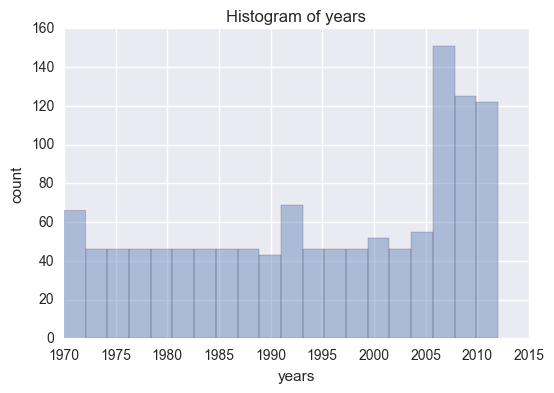

In [6]:
%matplotlib inline
if button_plots.value:
    DataVisualizations.distPlot(overall_data['year'],'Histogram of years','years','count',20,False)

### 2.3 Checking distrubution of the label visually

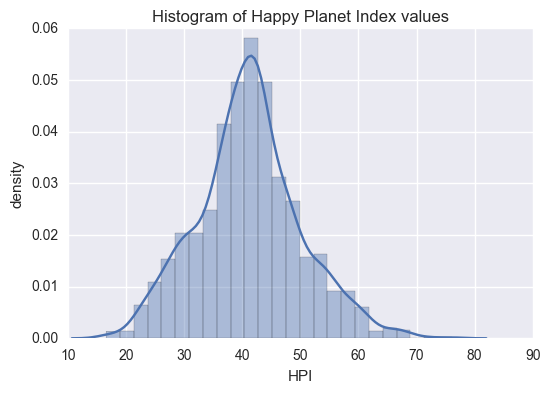

In [7]:
%matplotlib inline
if button_plots.value:
    DataVisualizations.distPlot(overall_data['Happy Planet Index'],'Histogram of Happy Planet Index values','HPI','density',25,True)

### 2.4 Most feature-target Correlated features in the data

In [8]:
HPI_correlation = overall_data[overall_data.columns[1:-1]].apply\
(lambda x: x.corr(overall_data['Happy Planet Index'], method='spearman'))
HPI_correlation = HPI_correlation.abs().sort_values(ascending=False)
HPI_correlation = pd.DataFrame({'Feature':HPI_correlation.index,\
                                'Correlation to Happy Planet Index':HPI_correlation.values})
HPI_correlation.head(5)

,Correlation to Happy Planet Index,Feature
0,0.244313,"Population, ages 15-64, female"
1,0.242787,Population of the official age for pre-primary...
2,0.242299,Population of the official age for pre-primary...
3,0.241668,Population of the official age for pre-primary...
4,0.241227,"Population, ages 15-64, total"


### 2.5 Plot Correlation matrix, taken 2 positive and 2 negative most correlated features

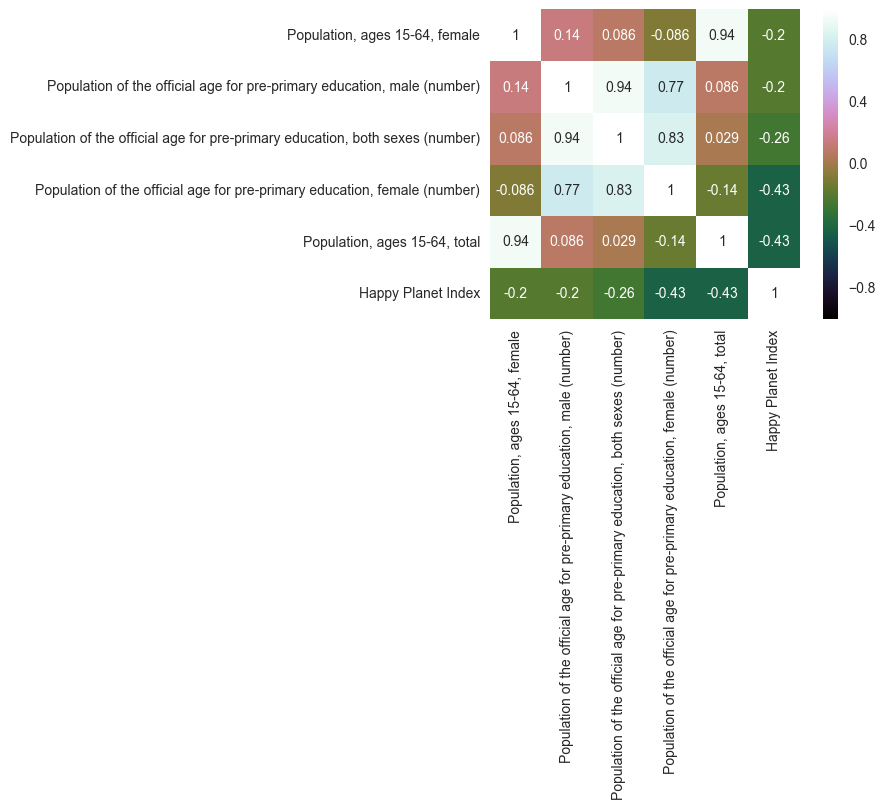

In [9]:
%matplotlib inline
corr_features = HPI_correlation['Feature'].head(5).tolist() + ['Happy Planet Index']
corr_features = [x for x in corr_features if x != 'year']
overall_data_to_plot = overall_data[corr_features]
data_corr_mat= overall_data_to_plot.corr(method='spearman')
c = data_corr_mat.corr(method='spearman')
if button_plots.value:
    sns.heatmap(c, vmax=1, square=True, annot=True, cmap='cubehelix')

### 2.6 Plotting Data on world map
#### Choose between Happy Planet Index and most correlated features 

In [10]:
if button_plots.value:
    MapVisualizations.interactMaps(overall_data,corr_features)

Please choose an option


## 3.Preprocessing

### 3.1 Impute nulls with medians

In [11]:
overall_data = overall_data.fillna(overall_data.median())
overall_data.head(5)

,country,year,"Enrolment in primary education, both sexes (number)","Enrolment in primary education, female (number)",GDP at market prices (constant 2005 US$),GDP at market prices (current US$),GDP per capita (constant 2005 US$),GDP per capita (current US$),GNI (current US$),"GNI per capita, Atlas method (current US$)",...,"Population, male (% of total)","Population, total","School life expectancy, primary, both sexes (years)","School life expectancy, primary, female (years)","School life expectancy, primary, gender parity index (GPI)","School life expectancy, primary, male (years)",Theoretical duration of pre-primary education (years),Theoretical duration of primary education (years),Theoretical duration of secondary education (years),Happy Planet Index
0,Afghanistan,2012.0,5767543.0,2348306.0,1.935220e+10,2.053654e+10,651.001852,690.842629,2.157185e+10,720.0,...,51.435962,29726803.0,6.53571,5.47000,0.72495,7.54532,4.0,6.0,6.0,36.8
2,Albania,2006.0,222402.0,107004.0,9.771760e+09,8.992642e+09,3265.365622,3005.012903,9.254605e+09,3090.0,...,50.260019,2992547.0,3.98375,3.97433,0.99544,3.99253,3.0,4.0,8.0,42.1
3,Albania,2009.0,236102.0,112399.0,1.150029e+10,1.204421e+10,3928.340828,4114.136545,1.185274e+10,4280.0,...,50.432577,2927519.0,4.80613,4.74382,0.97524,4.86425,3.0,5.0,7.0,47.9
4,Albania,2012.0,206617.0,97583.0,1.240477e+10,1.231978e+10,4277.143310,4247.839852,1.222802e+10,4360.0,...,50.128703,2900247.0,5.16259,5.09023,0.97326,5.23009,3.0,5.0,7.0,54.1
6,Algeria,2006.0,4196580.0,1973901.0,1.446470e+11,1.170270e+11,4285.934521,3467.544740,1.126050e+11,3100.0,...,50.489699,33749328.0,6.40438,6.17532,0.93223,6.62422,1.0,6.0,6.0,45.9


### 3.2 One Hot Encoding Foreach Country

In [12]:
overall_data_countries = overall_data['country']
oh_overall_data = overall_data.drop('country', axis=1)
onehot_overall_col = pd.get_dummies(overall_data['country'], prefix='country')

#check for missing cols in onehot_overall_col
for col in onehot_overall_col.columns:
    if col not in onehot_overall_col.columns:
        onehot_overall_col[col] = 0
        
oh_overall_data = pd.concat([oh_overall_data, onehot_overall_col], axis=1)
overall_data = oh_overall_data
overall_data['country'] = overall_data_countries
overall_data.head(5)

,year,"Enrolment in primary education, both sexes (number)","Enrolment in primary education, female (number)",GDP at market prices (constant 2005 US$),GDP at market prices (current US$),GDP per capita (constant 2005 US$),GDP per capita (current US$),GNI (current US$),"GNI per capita, Atlas method (current US$)","Gross enrolment ratio, primary, both sexes (%)",...,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Vietnam,country_Zambia,country_Zimbabwe,country
0,2012.0,5767543.0,2348306.0,1.935220e+10,2.053654e+10,651.001852,690.842629,2.157185e+10,720.0,108.928520,...,0,0,0,0,0,0,0,0,0,Afghanistan
2,2006.0,222402.0,107004.0,9.771760e+09,8.992642e+09,3265.365622,3005.012903,9.254605e+09,3090.0,99.593842,...,0,0,0,0,0,0,0,0,0,Albania
3,2009.0,236102.0,112399.0,1.150029e+10,1.204421e+10,3928.340828,4114.136545,1.185274e+10,4280.0,97.525330,...,0,0,0,0,0,0,0,0,0,Albania
4,2012.0,206617.0,97583.0,1.240477e+10,1.231978e+10,4277.143310,4247.839852,1.222802e+10,4360.0,104.784393,...,0,0,0,0,0,0,0,0,0,Albania
6,2006.0,4196580.0,1973901.0,1.446470e+11,1.170270e+11,4285.934521,3467.544740,1.126050e+11,3100.0,108.287209,...,0,0,0,0,0,0,0,0,0,Algeria


### 3.3 Split Data randomly into training set and test set

In [13]:
train_data, test_data = train_test_split\
(overall_data, test_size = 0.2, random_state=0)
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
train_data.head(5)

,year,"Enrolment in primary education, both sexes (number)","Enrolment in primary education, female (number)",GDP at market prices (constant 2005 US$),GDP at market prices (current US$),GDP per capita (constant 2005 US$),GDP per capita (current US$),GNI (current US$),"GNI per capita, Atlas method (current US$)","Gross enrolment ratio, primary, both sexes (%)",...,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Vietnam,country_Zambia,country_Zimbabwe,country
0,2009.0,406920.0,200909.0,1.063964e+10,8.876191e+09,4943.249801,4123.939997,8.708821e+09,4120.0,108.228012,...,0,0,0,0,0,0,0,0,0,Namibia
1,1985.0,420665.0,205210.0,6.420870e+10,2.129391e+10,18147.884040,6018.489552,1.983712e+10,5630.0,95.102722,...,0,0,0,0,0,0,0,0,0,Ireland
2,1984.0,888440.0,430238.0,1.813080e+11,4.802002e+10,18321.674990,4852.565728,4.851687e+10,5130.0,105.983048,...,0,0,0,0,0,0,0,0,0,Greece
3,1991.0,2820497.0,1366826.0,8.954290e+11,5.755990e+11,22995.652240,14782.038900,5.713820e+11,13720.0,105.279709,...,0,0,0,0,0,0,0,0,0,Spain
4,2006.0,364263.0,161875.0,2.179437e+09,1.211162e+09,506.323083,281.375017,1.202459e+09,280.0,68.011917,...,0,0,0,0,0,0,0,0,0,Eritrea


### 3.4 Partition factors, class and countries

In [14]:
train_countries = train_data['country']
train_class = train_data['Happy Planet Index']
train_factors = (train_data.drop(['Happy Planet Index', 'country'], axis=1))

test_countries = test_data['country']
test_class = test_data['Happy Planet Index']
test_factors =(test_data.drop(['Happy Planet Index', 'country'], axis=1))

train_factors.head(5)

,year,"Enrolment in primary education, both sexes (number)","Enrolment in primary education, female (number)",GDP at market prices (constant 2005 US$),GDP at market prices (current US$),GDP per capita (constant 2005 US$),GDP per capita (current US$),GNI (current US$),"GNI per capita, Atlas method (current US$)","Gross enrolment ratio, primary, both sexes (%)",...,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Vietnam,country_Zambia,country_Zimbabwe
0,2009.0,406920.0,200909.0,1.063964e+10,8.876191e+09,4943.249801,4123.939997,8.708821e+09,4120.0,108.228012,...,0,0,0,0,0,0,0,0,0,0
1,1985.0,420665.0,205210.0,6.420870e+10,2.129391e+10,18147.884040,6018.489552,1.983712e+10,5630.0,95.102722,...,0,0,0,0,0,0,0,0,0,0
2,1984.0,888440.0,430238.0,1.813080e+11,4.802002e+10,18321.674990,4852.565728,4.851687e+10,5130.0,105.983048,...,0,0,0,0,0,0,0,0,0,0
3,1991.0,2820497.0,1366826.0,8.954290e+11,5.755990e+11,22995.652240,14782.038900,5.713820e+11,13720.0,105.279709,...,0,0,0,0,0,0,0,0,0,0
4,2006.0,364263.0,161875.0,2.179437e+09,1.211162e+09,506.323083,281.375017,1.202459e+09,280.0,68.011917,...,0,0,0,0,0,0,0,0,0,0


### 3.5 Binning The Years by Decades

In [15]:
min_year = min(min(train_factors['year']), min(test_factors['year']))
train_factors['year'] = train_factors['year'].apply(lambda x:math.floor((x-min_year) / 10))
test_factors['year'] = test_factors['year'].apply(lambda x:math.floor((x-min_year) / 10))
train_factors.head(5)

,year,"Enrolment in primary education, both sexes (number)","Enrolment in primary education, female (number)",GDP at market prices (constant 2005 US$),GDP at market prices (current US$),GDP per capita (constant 2005 US$),GDP per capita (current US$),GNI (current US$),"GNI per capita, Atlas method (current US$)","Gross enrolment ratio, primary, both sexes (%)",...,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Vietnam,country_Zambia,country_Zimbabwe
0,3,406920.0,200909.0,1.063964e+10,8.876191e+09,4943.249801,4123.939997,8.708821e+09,4120.0,108.228012,...,0,0,0,0,0,0,0,0,0,0
1,1,420665.0,205210.0,6.420870e+10,2.129391e+10,18147.884040,6018.489552,1.983712e+10,5630.0,95.102722,...,0,0,0,0,0,0,0,0,0,0
2,1,888440.0,430238.0,1.813080e+11,4.802002e+10,18321.674990,4852.565728,4.851687e+10,5130.0,105.983048,...,0,0,0,0,0,0,0,0,0,0
3,2,2820497.0,1366826.0,8.954290e+11,5.755990e+11,22995.652240,14782.038900,5.713820e+11,13720.0,105.279709,...,0,0,0,0,0,0,0,0,0,0
4,3,364263.0,161875.0,2.179437e+09,1.211162e+09,506.323083,281.375017,1.202459e+09,280.0,68.011917,...,0,0,0,0,0,0,0,0,0,0


### 3.6 Change all numeric values' datatypes to float

In [16]:
train_factors = train_factors.astype(np.float)
test_factors = test_factors.astype(np.float)
train_factors.dtypes[:5]

year                                                   float64
Enrolment in primary education, both sexes (number)    float64
Enrolment in primary education, female (number)        float64
GDP at market prices (constant 2005 US$)               float64
GDP at market prices (current US$)                     float64
dtype: object

### 3.7 Creating a yearless and countryless copies of the data
#### Henceforth, we duplicate our actions handling the data for each copy 

In [17]:
alternativeModles = creatAlternativeModels(train_data, train_factors, train_class, train_countries, test_data, test_factors,\
                                       test_class, test_countries)

### 3.8 Data linearity proving

#### 3.8.1 For our main data

Applying OLS on train data and checking model assumptions
train R^2: 0.8641 
residuals appear to behave randomly, it suggests that the linear model fits the data well


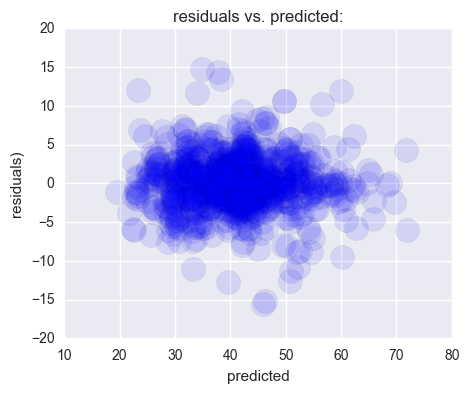

residuals appear to be normally distributed


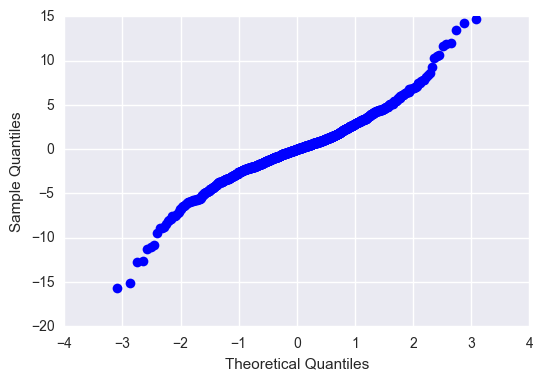

In [18]:
OutliersDetection.linearityProving(train_factors, train_class, button_plots.value)

#### 3.8.2 For the yearless and countryless copies

In [19]:
interact(OutliersDetection.allDataLinearityProving,\
             request=RadioButtons(options=  ['None'] + dataTypes,\
                                  description='Select data type for linearity check:', disabled=False))

Please choose an option


<function utilities.OutliersDetection.allDataLinearityProving>

### 3.9 Centering and Scaling nomeric features, and removing features with: $STD\approx0$ 

#### 3.9.1 For our main data

In [20]:
train_factors = pd.DataFrame(sp.StandardScaler().fit_transform(train_factors),columns = train_factors.columns)
test_factors = pd.DataFrame(sp.StandardScaler().fit_transform(test_factors),columns = test_factors.columns)
train_factors.head(5)

,year,"Enrolment in primary education, both sexes (number)","Enrolment in primary education, female (number)",GDP at market prices (constant 2005 US$),GDP at market prices (current US$),GDP per capita (constant 2005 US$),GDP per capita (current US$),GNI (current US$),"GNI per capita, Atlas method (current US$)","Gross enrolment ratio, primary, both sexes (%)",...,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Vietnam,country_Zambia,country_Zimbabwe
0,0.780879,-0.287638,-0.296172,-0.514255,-0.378689,-1.064374,-0.728401,-0.374095,-0.745905,0.612859,...,-0.063758,-0.045038,-0.176961,-0.055188,-0.055188,-0.045038,-0.03183,-0.063758,-0.03183,-0.055188
1,-0.782461,-0.286277,-0.295247,-0.471274,-0.367663,-0.355682,-0.598975,-0.364349,-0.637493,-0.809469,...,-0.063758,-0.045038,-0.176961,-0.055188,-0.055188,-0.045038,-0.03183,-0.063758,-0.03183,-0.055188
2,-0.782461,-0.239970,-0.246859,-0.377320,-0.343932,-0.346354,-0.678625,-0.339231,-0.673391,0.369583,...,-0.063758,-0.045038,-0.176961,-0.055188,-0.055188,-0.045038,-0.03183,-0.063758,-0.03183,-0.055188
3,-0.000791,-0.048709,-0.045464,0.195653,0.124527,-0.095502,-0.000298,0.118704,-0.056662,0.293365,...,-0.063758,-0.045038,-0.176961,-0.055188,-0.055188,-0.045038,-0.03183,-0.063758,-0.03183,-0.055188
4,0.780879,-0.291860,-0.304565,-0.521043,-0.385495,-1.302503,-0.990904,-0.380670,-1.021603,-3.745178,...,-0.063758,-0.045038,-0.176961,-0.055188,-0.055188,-0.045038,-0.03183,-0.063758,-0.03183,-0.055188


#### 3.9.2 For the yearless and countryless copies

In [21]:
for data in dataTypes:
    alternativeModles[data].train_factors = \
            pd.DataFrame(sp.StandardScaler().fit_transform(alternativeModles[data].train_factors),columns =\
                                          alternativeModles[data].train_factors.columns)
    alternativeModles[data].test_factors = \
            pd.DataFrame(sp.StandardScaler().fit_transform(alternativeModles[data].test_factors),columns =\
                                          alternativeModles[data].test_factors.columns)
updateAlternativeModles(alternativeModles)

## 4. Outliers Detection

### 4.1 Robust Regression Method

#### 4.1.1 For our main data

Stage 0
validation R^2, 0.9128 


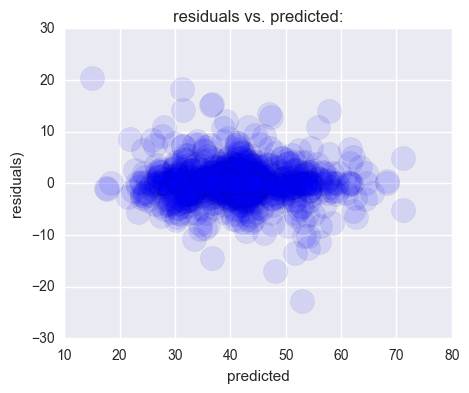

44 rows were dropped
After final stage
validation R^2, 0.9543 


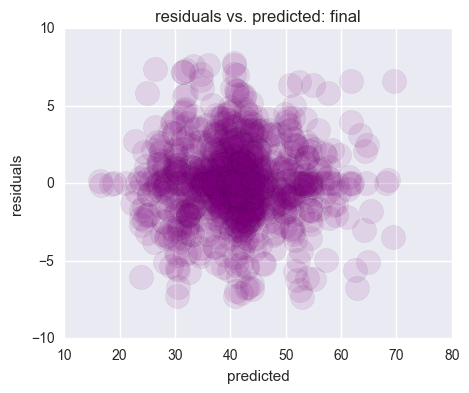

In [22]:
train_factors, train_class, train_data =\
OutliersDetection.removeOutliersRlm(train_factors, train_class, train_data, 1, button_plots.value)

#### 4.1.2 For the yearless and countryless copies

Stage 0
validation R^2, 0.4555 


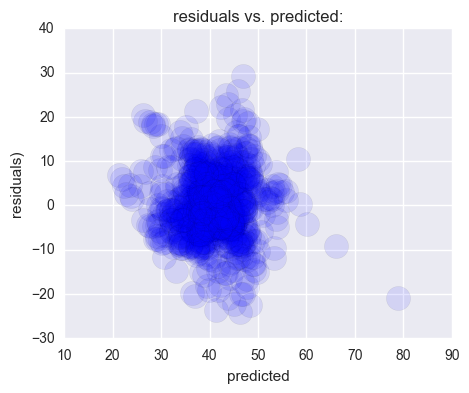

49 rows were dropped
After final stage
validation R^2, 0.5875 


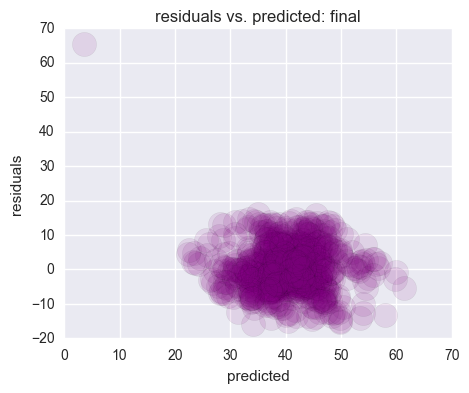

Stage 0
validation R^2, 0.9075 


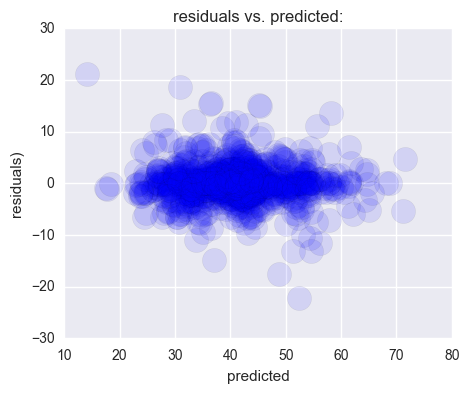

38 rows were dropped
After final stage
validation R^2, 0.9554 


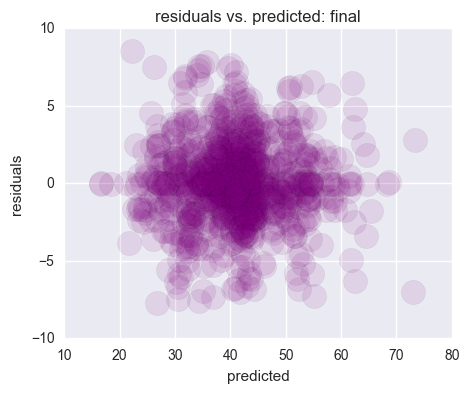

In [23]:
for data in dataTypes:
    alternativeModles[data].train_factors, alternativeModles[data].train_class, alternativeModles[data].train_data =\
                                OutliersDetection.removeOutliersRlm(alternativeModles[data].train_factors, \
                                                                    alternativeModles[data].train_class, \
                                                                alternativeModles[data].train_data, 1, button_plots.value)
updateAlternativeModles(alternativeModles)

### 4.2 PCA Visual Method

#### 4.2.1 Apply 2D-PCA dimension reduction for visual outliers detection 

##### 4.2.1.1 For our main data

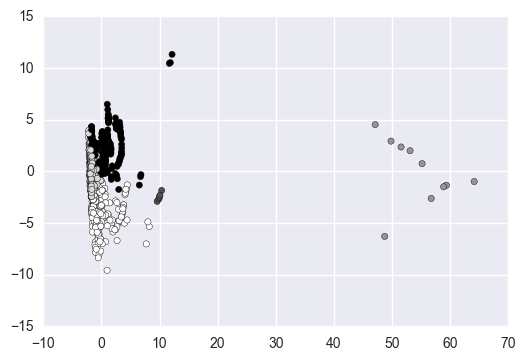

In [24]:
plot_columns, labels = DataVisualizations.twoDimPCAandClustering(train_factors, button_plots.value)

##### 4.2.1.2 For the yearless and countryless copies

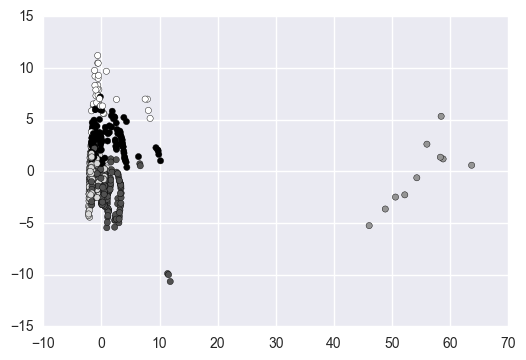

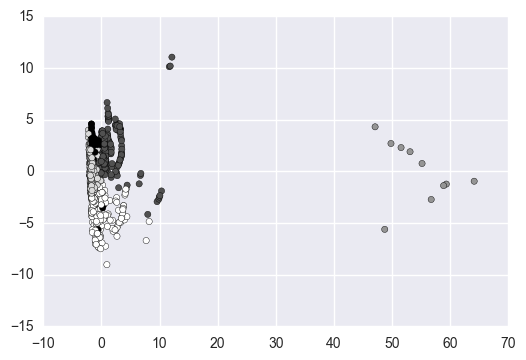

In [25]:
PCAAltModels = dict([(data,(DataVisualizations.twoDimPCAandClustering(alternativeModles[data].train_factors,\
                                                                      button_plots.value))) for data in dataTypes])
updateAlternativeModles(alternativeModles)

#### 4.2.2 Print outliers' countries

##### 4.2.2.1 For our main data

In [26]:
outliers_indecies = np.where(plot_columns[:,0] > 20)[0].tolist()
outliers_df = train_data.loc[outliers_indecies, :]
outliers_df['country'].head(min(10, len(outliers_indecies)))

17     India
256    China
259    India
300    China
426    China
432    India
451    China
636    China
730    China
800    India
Name: country, dtype: object

##### 4.2.2.2 For the yearless and countryless copies

In [27]:
outliers_indecies_AltModels = dict([(data,np.where(PCAAltModels[data][0][:,0] > 20)[0].tolist()) for data in dataTypes])
outliers_df_AltModels = dict([(data,alternativeModles[data].train_data.loc[outliers_indecies_AltModels[data], :]) for data \
                             in dataTypes])
OutliersDetection.printOutlierCountries(outliers_df_AltModels,outliers_indecies_AltModels)

Please choose an option


#### 4.2.3 Remove visible outliers if reducing aquracy

##### 4.2.3.1 For our main data

In [28]:
train_factors, train_class, train_data =\
OutliersDetection.removeOutliersPCA(train_factors, train_class, train_data, outliers_indecies, button_plots.value)

R^2 on validation set with outliers: 0.904946241467 , and without outliers: 0.910812702711
Leaving outliers in the training set.


##### 4.2.3.2 For the yearless and countryless copies

In [29]:
for data in dataTypes:
    print(data+" run:")
    alternativeModles[data].train_factors, alternativeModles[data].train_class, alternativeModles[data].train_data =\
                                OutliersDetection.removeOutliersPCA(alternativeModles[data].train_factors,\
                                                                    alternativeModles[data].train_class,\
                                                                    alternativeModles[data].train_data,\
                                                                    outliers_indecies_AltModels[data], False)
updateAlternativeModles(alternativeModles)

no countries run:
R^2 on validation set with outliers: 0.410568418316 , and without outliers: 0.458319744672
Removing outliers from training set.
no years run:
R^2 on validation set with outliers: 0.900838982776 , and without outliers: 0.905329255707
Leaving outliers in the training set.


## 5. Feature selection with E.Net model

### 5.1 Feature selection function definition

In [30]:
def featureSelectionWithENET(train_factors, train_class):
    # run elastic model for feature selection 
    enet = ElasticNetCV(max_iter=5000, cv=5, n_jobs=-1)
    enet.fit(train_factors, train_class)

    sfm = fs.SelectFromModel(enet, prefit=True)
    chosen_features_and_coefs = [(train_factors.columns[i],enet.coef_[i]) for i in sfm.get_support(True)]

    chosen_features_and_coefs.sort(key=lambda x:abs(x[1]), reverse=True)
    headers = [['correlated feature', 'coefficient value']]
    data = headers + [[x[0], x[1]]\
                      for x in chosen_features_and_coefs if not x[0].startswith('country_')]
    headers = data.pop(0) # gives the headers as list and leaves data
    table = pd.DataFrame(data, columns=headers)
    print("Enet Strong factors (countries features not included) are: ")
    return chosen_features_and_coefs, table

#### 5.1.1 selected features for our main data

In [31]:
chosen_features_and_coefs, table = featureSelectionWithENET(train_factors, train_class)
table.head(table.shape[0])

Enet Strong factors (countries features not included) are: 


,correlated feature,coefficient value
0,Official entrance age to primary education (ye...,-1.048629
1,year,0.868307
2,Population growth (annual %),-0.756785
3,"GNI per capita, Atlas method (current US$)",0.720074
4,Official entrance age to pre-primary education...,-0.692780
5,"School life expectancy, primary, both sexes (y...",-0.637872
6,"Gross enrolment ratio, primary, male (%)",0.467818
7,Theoretical duration of secondary education (y...,-0.354008
8,"Mortality rate, under-5 (per 1,000)",-0.342744


In [32]:
# chosen_features_and_coefs_AltModels = dict([(data,chosen_features_and_coefs) for data in dataTypes])
# for data in dataTypes:
#     # run elastic model for feature selection 
#     enet = ElasticNetCV(max_iter=5000, cv=5, n_jobs=-1)
#     enet.fit(alternativeModles[data].train_factors, alternativeModles[data].train_class)

#     sfm = fs.SelectFromModel(enet, prefit=True)
#     chosen_features_and_coefs_AltModels[data] = [(alternativeModles[data].train_factors.columns[i],enet.coef_[i]) for i in sfm.get_support(True)]

#     chosen_features_and_coefs_AltModels[data].sort(key=lambda x:abs(x[1]), reverse=True)
#     headers = [['correlated feature', 'coefficient value']]
#     curData = headers + [[x[0], x[1]]\
#                       for x in chosen_features_and_coefs_AltModels[data] if not x[0].startswith('country_')]
#     headers = curData.pop(0) # gives the headers as list and leaves data
#     table = pd.DataFrame(curData, columns=headers)
#     print("Enet Strong factors for data:",data," are: ")
#     print(table.head(table.shape[0]))

#### 5.1.2 selected features for the yearless and countryless copies

In [33]:
chosen_features_and_coefs_AltModels = dict([(data,chosen_features_and_coefs) for data in dataTypes]) 

### 5.2 Countries correlated to target plot

#### 5.2.1 For our main data

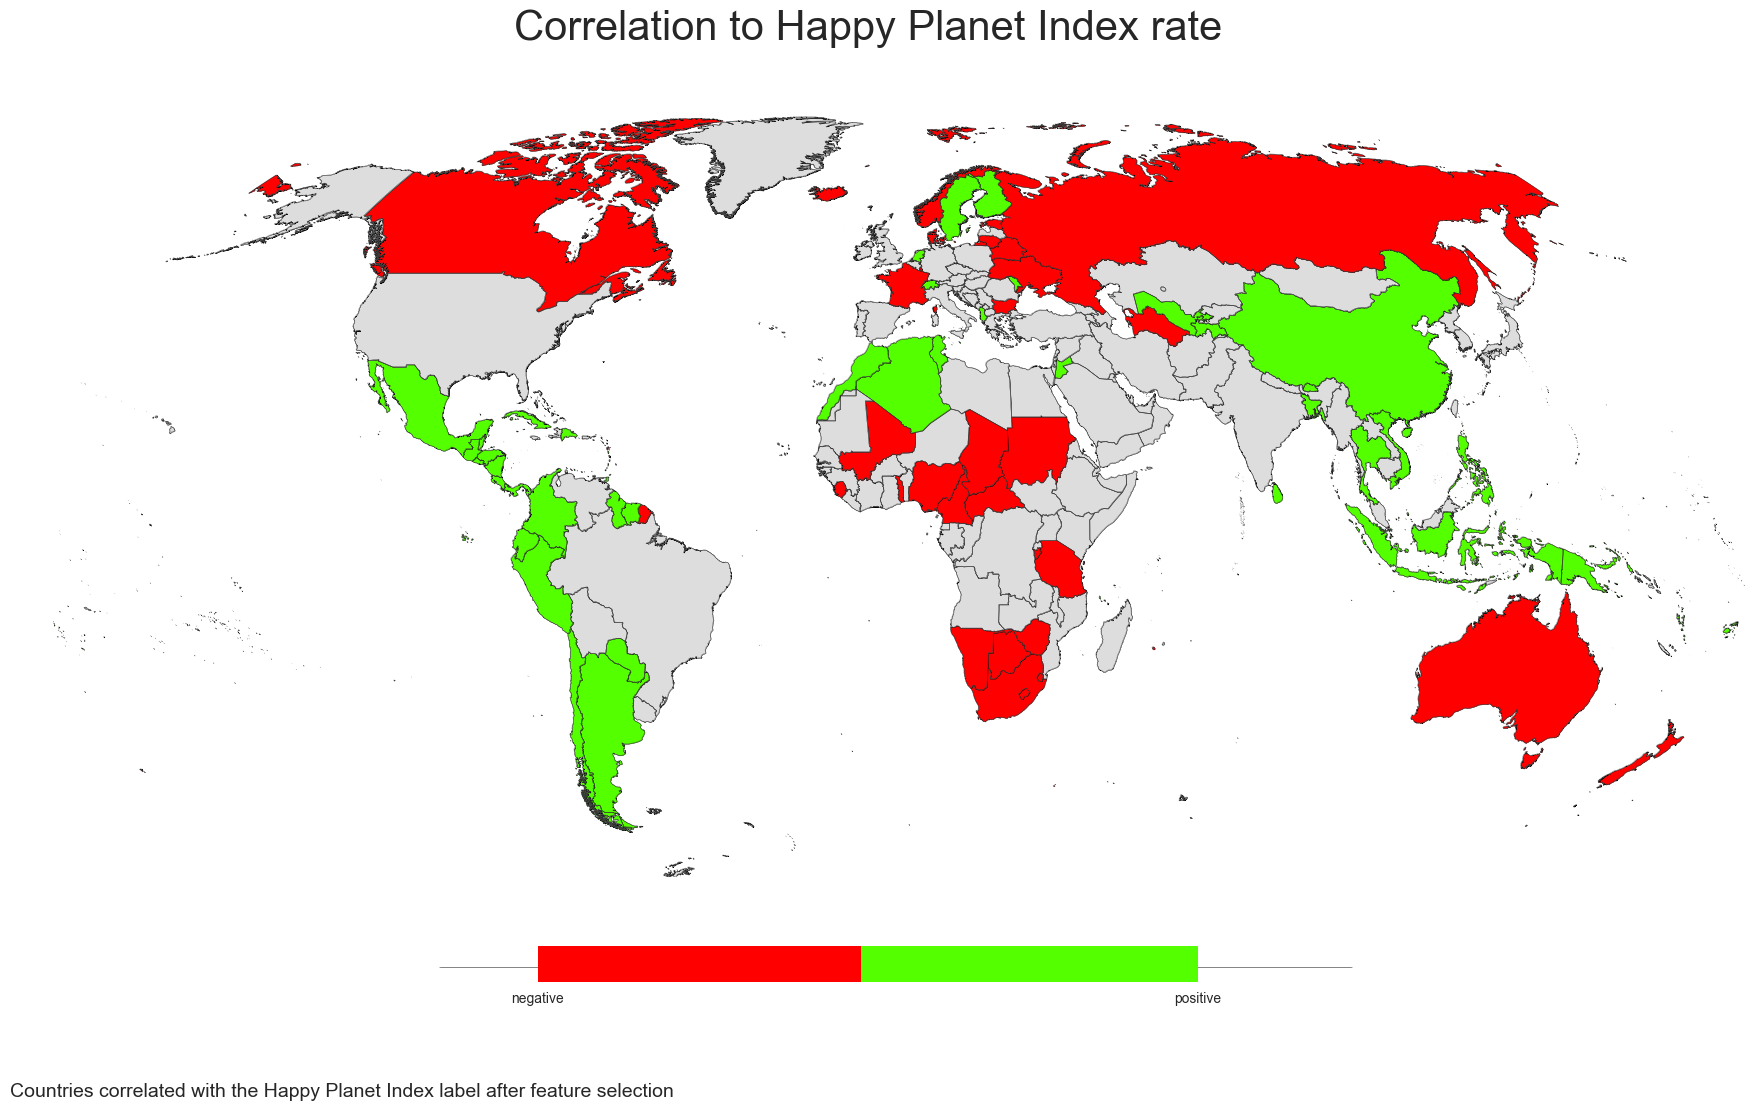

In [34]:
if button_plots.value:
    headers = [['country', 'Correlation to Happy Planet Index']]
    data = headers + [[x[0].split('country_')[1], np.sign(x[1])]\
                      for x in chosen_features_and_coefs if x[0].startswith('country_')]
    headers = data.pop(0) # gives the headers as list and leaves data
    df = pd.DataFrame(data, columns=headers)
    MapVisualizations.plotDataOnMap(df, year='mean', feature="Correlation to Happy Planet Index", binary=True,\
                  descripton='Countries correlated with the Happy Planet Index label after feature selection')

#### 5.2.2 For the yearless and countryless copies

### 5.3 Take remaining features

#### 5.3.1 For our main data

In [35]:
chosen_features = [x[0] for x in chosen_features_and_coefs]
train_factors = train_factors[chosen_features]
test_factors = test_factors[chosen_features]
train_factors.head(5)

,country_Mexico,country_Luxembourg,country_Switzerland,country_Sweden,country_Vietnam,country_Norway,country_Costa Rica,country_Guatemala,country_New Zealand,country_Netherlands,...,country_Uzbekistan,country_Timor-Leste,country_Paraguay,country_Cameroon,country_Mali,country_Papua New Guinea,country_Algeria,country_Malta,Theoretical duration of secondary education (years),"Mortality rate, under-5 (per 1,000)"
0,-0.176961,-0.170783,-0.170783,-0.167618,-0.063758,-0.176961,-0.045038,-0.055188,-0.170783,-0.17998,...,-0.045038,-0.03183,-0.055188,-0.055188,-0.055188,-0.03183,-0.045038,-0.045038,-1.698836,1.091002
1,-0.176961,-0.170783,-0.170783,-0.167618,-0.063758,-0.176961,-0.045038,-0.055188,-0.170783,-0.17998,...,-0.045038,-0.03183,-0.055188,-0.055188,-0.055188,-0.03183,-0.045038,-0.045038,-1.698836,-0.416986
2,-0.176961,-0.170783,-0.170783,-0.167618,-0.063758,-0.176961,-0.045038,-0.055188,-0.170783,-0.17998,...,-0.045038,-0.03183,-0.055188,-0.055188,-0.055188,-0.03183,-0.045038,-0.045038,-0.551570,-0.161284
3,-0.176961,-0.170783,-0.170783,-0.167618,-0.063758,-0.176961,-0.045038,-0.055188,-0.170783,-0.17998,...,-0.045038,-0.03183,-0.055188,-0.055188,-0.055188,-0.03183,-0.045038,-0.045038,0.595696,-0.423543
4,-0.176961,-0.170783,-0.170783,-0.167618,-0.063758,-0.176961,-0.045038,-0.055188,-0.170783,-0.17998,...,-0.045038,-0.03183,-0.055188,-0.055188,-0.055188,-0.03183,-0.045038,-0.045038,0.595696,1.405713


#### 5.3.2 For the yearless and countryless copies

In [36]:
for data in dataTypes:
    chosen_features = [x[0] for x in chosen_features_and_coefs_AltModels[data]]
    alternativeModles[data].train_factors = alternativeModles[data].train_factors[chosen_features]
    alternativeModles[data].test_factors = alternativeModles[data].test_factors[chosen_features]

KeyError: "['country_Mexico' 'country_Luxembourg' 'country_Switzerland'\n 'country_Sweden' 'country_Vietnam' 'country_Norway' 'country_Costa Rica'\n 'country_Guatemala' 'country_New Zealand' 'country_Netherlands'\n 'country_Indonesia' 'country_Zimbabwe' 'country_Cuba' 'country_Panama'\n 'country_Morocco' 'country_Australia' 'country_Denmark' 'country_Vanuatu'\n 'country_Botswana' 'country_Honduras' 'country_El Salvador'\n 'country_Colombia' 'country_Dominican Republic' 'country_Togo'\n 'country_Estonia' 'country_Nicaragua' 'country_Jordan'\n 'country_Tajikistan' 'country_Central African Republic' 'country_Canada'\n 'country_Ecuador' 'country_Dominica' 'country_Chile' 'country_Burundi'\n 'country_Sierra Leone' 'country_Belize' 'country_Bhutan'\n 'country_Argentina' 'country_Swaziland' 'country_Bulgaria'\n 'country_Philippines' 'country_Namibia' 'country_Bangladesh'\n 'country_Chad' 'country_South Africa' 'country_Thailand' 'country_Moldova'\n 'country_Comoros' 'country_St. Vincent and the Grenadines'\n 'country_Russian Federation' 'country_Lesotho' 'country_Sudan'\n 'country_Peru' 'country_China' 'country_Iceland' 'country_Tanzania'\n 'country_France' 'country_Guyana' 'country_Trinidad and Tobago'\n 'country_Lithuania' 'country_Turkmenistan' 'country_Suriname'\n 'country_Ukraine' 'country_Finland' 'country_Belarus'\n 'country_Antigua and Barbuda' 'country_Tonga' 'country_Tunisia'\n 'country_Sri Lanka' 'country_Nigeria' 'country_Albania' 'country_Fiji'\n 'country_Uzbekistan' 'country_Timor-Leste' 'country_Paraguay'\n 'country_Cameroon' 'country_Mali' 'country_Papua New Guinea'\n 'country_Algeria' 'country_Malta'] not in index"

## 6. Features extraction
#### Checking feature interactions' correlations to label

### 6.1 Synthesizing features' interactions

In [37]:
poly = sp.PolynomialFeatures(2, include_bias=False)
transf_train = poly.fit_transform(train_factors)
transf_test = poly.fit_transform(test_factors)
target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(train_factors.columns,p) for p in poly.powers_]]
train_factors_after_extracion = (pd.DataFrame(transf_train, columns = target_feature_names))
test_factors_after_extracion = (pd.DataFrame(transf_test, columns = target_feature_names))
train_factors_after_extracion.head(5)

,country_Mexico^1,country_Luxembourg^1,country_Switzerland^1,country_Sweden^1,country_Vietnam^1,country_Norway^1,country_Costa Rica^1,country_Guatemala^1,country_New Zealand^1,country_Netherlands^1,...,country_Algeria^2,country_Algeria^1xcountry_Malta^1,country_Algeria^1xTheoretical duration of secondary education (years)^1,"country_Algeria^1xMortality rate, under-5 (per 1,000)^1",country_Malta^2,country_Malta^1xTheoretical duration of secondary education (years)^1,"country_Malta^1xMortality rate, under-5 (per 1,000)^1",Theoretical duration of secondary education (years)^2,"Theoretical duration of secondary education (years)^1xMortality rate, under-5 (per 1,000)^1","Mortality rate, under-5 (per 1,000)^2"
0,-0.176961,-0.170783,-0.170783,-0.167618,-0.063758,-0.176961,-0.045038,-0.055188,-0.170783,-0.17998,...,0.002028,0.002028,0.076512,-0.049136,0.002028,0.076512,-0.049136,2.886045,-1.853434,1.190285
1,-0.176961,-0.170783,-0.170783,-0.167618,-0.063758,-0.176961,-0.045038,-0.055188,-0.170783,-0.17998,...,0.002028,0.002028,0.076512,0.018780,0.002028,0.076512,0.018780,2.886045,0.708391,0.173877
2,-0.176961,-0.170783,-0.170783,-0.167618,-0.063758,-0.176961,-0.045038,-0.055188,-0.170783,-0.17998,...,0.002028,0.002028,0.024841,0.007264,0.002028,0.024841,0.007264,0.304230,0.088959,0.026012
3,-0.176961,-0.170783,-0.170783,-0.167618,-0.063758,-0.176961,-0.045038,-0.055188,-0.170783,-0.17998,...,0.002028,0.002028,-0.026829,0.019075,0.002028,-0.026829,0.019075,0.354854,-0.252303,0.179388
4,-0.176961,-0.170783,-0.170783,-0.167618,-0.063758,-0.176961,-0.045038,-0.055188,-0.170783,-0.17998,...,0.002028,0.002028,-0.026829,-0.063310,0.002028,-0.026829,-0.063310,0.354854,0.837377,1.976028


### 6.2 Checking correlations between target and synthesized features

In [38]:
poly = sp.PolynomialFeatures(2, include_bias=False)
transf_train = poly.fit_transform(train_factors)
target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(train_factors.columns,p) for p in poly.powers_]]
train_factors_after_extracion = (pd.DataFrame(transf_train, columns = target_feature_names))

max_corr_before = HPI_correlation['Correlation to Happy Planet Index'].iloc[0]
HPI_correlation_feature_extraction = train_factors_after_extracion[train_factors_after_extracion.columns[:]].apply\
(lambda x: x.corr(train_data['Happy Planet Index'], method='spearman'))
HPI_correlation_feature_extraction = HPI_correlation_feature_extraction.abs().sort_values(ascending=False)
HPI_correlation_feature_extraction = pd.DataFrame({'Feature':HPI_correlation_feature_extraction.index,\
                                'Correlation to Happy Planet Index':HPI_correlation_feature_extraction.values})
HPI_correlation_feature_extraction = HPI_correlation_feature_extraction.loc\
[(HPI_correlation_feature_extraction["Correlation to Happy Planet Index"] > max_corr_before) \
 & ((HPI_correlation_feature_extraction["Feature"].str.count("\^") == 2) | ((HPI_correlation_feature_extraction["Feature"].str.count("\^2") == 1)))]
print('There are', HPI_correlation_feature_extraction.shape[0],\
      'new features that are more corrolative to target then old features and many other new very correlative features')
HPI_correlation_feature_extraction.head(5)

There are 93 new features that are more corrolative to target then old features and many other new very correlative features


,Correlation to Happy Planet Index,Feature
0,0.322989,country_Luxembourg^1xcountry_Denmark^1
1,0.319492,country_Luxembourg^1xcountry_Norway^1
2,0.312567,country_Luxembourg^1xcountry_Australia^1
3,0.307399,country_Mexico^1xcountry_Netherlands^1
4,0.305112,country_Mexico^1xcountry_Switzerland^1


## 7. Model - Kernel ridge regression

#### We use this model with the kernel trick due to the positive results of section 6.2

In [39]:
param_grid_for_kridge = {'alpha': [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12],\
              'gamma': [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12]}
model = GridSearchCV(KernelRidge(kernel='polynomial', degree=2),\
                     cv=5, param_grid=param_grid_for_kridge, n_jobs=-1, verbose=1)

ridgeKernelResults = ResultsMeasurements(button_exec.value, train_data,test_data,train_factors,test_factors,\
                                         train_class,test_class,model,'kernel ridge resgression')
ridgeKernelResults.interactResults()

Please choose an option


# Model Evaluation

## Linear Regression

In [ ]:
lr = LinearRegression()
linearRegResults = ResultsMeasurements(not(button_exec.value), train_data,test_data,train_factors,test_factors,\
                                       train_class,test_class,lr , 'linear regression')
linearRegResults.interactResults()

## Lasso Regression

In [ ]:
lasso = linear_model.Lasso(alpha=0.1)
lassoResults = ResultsMeasurements(button_exec.value, train_data,test_data,train_factors,test_factors,\
                                   train_class,test_class,lasso, 'lasso resgression')
lassoResults.interactResults()


## Ridge Regression

In [ ]:
ridge = Ridge(alpha=1.0)
ridgeResults = ResultsMeasurements(button_exec.value, train_data,test_data,train_factors,test_factors,\
                                   train_class,test_class,ridge,'ridge resgression')
ridgeResults.interactResults()


## Random Forest - The Chosen Model

In [ ]:
param_grid_for_random_forest = {'max_features': [None, 'sqrt', 'log2'],\
                    'n_estimators': [500, 1000, 1500], 'max_depth': [None, 1, 5, 10, 50], 'min_samples_split':\
                    [2, 3, 4, 5], 'min_samples_leaf':[1, 3, 5, 7, 9]}
clf = GridSearchCV(RandomForestRegressor(), param_grid=param_grid_for_random_forest, cv=5,
                  n_jobs=-1, verbose=1)
randomForestResults = ResultsMeasurements(button_exec.value, train_data,test_data,train_factors,test_factors,\
                                          train_class,test_class,clf,'random forest resgression')
randomForestResults.interactResults()

In [ ]:
results = dict([(data,0) for data in dataTypes])
for data in dataTypes:
    results[data] = ResultsMeasurements(False, alternativeModles[data].train_data,\
                                             alternativeModles[data].test_data,\
                                             alternativeModles[data].train_factors,\
                                             alternativeModles[data].test_factors,\
                                             alternativeModles[data].train_class,\
                                             alternativeModles[data].test_class,\
                                             clf,'random forest resgression '+data)

In [ ]:
print(results['no countries'].trainFactors.shape)
print(results['no countries'].trainRelevantData['label'].shape)

In [ ]:
results['no countries'].interactResults()

In [ ]:
results['no years'].interactResults()

In [ ]:
data='no years'
print(alternativeModles[data].train_data.shape,\
                                             alternativeModles[data].test_data.shape,\
                                             alternativeModles[data].train_factors.shape,\
                                             alternativeModles[data].test_factors.shape,\
                                             alternativeModles[data].train_class.shape,\
                                             alternativeModles[data].test_class.shape)

In [ ]:
data='no countries'
print(alternativeModles[data].train_data.shape,\
                                             alternativeModles[data].test_data.shape,\
                                             alternativeModles[data].train_factors.shape,\
                                             alternativeModles[data].test_factors.shape,\
                                             alternativeModles[data].train_class.shape,\
                                             alternativeModles[data].test_class.shape)